In [20]:
# =======================================================
# FraudFinder - Model Notebook
# notebooks/2_model.ipynb
# Contains model building and evaluation
# =======================================================

## 1. Imports

In [21]:
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from xgboost import XGBClassifier


## 2. Load data

In [22]:
# Get current working directory (notebook runtime location)
current_dir = os.getcwd()

# Construct path to the CSV file
pro_path = os.path.join(current_dir, "..", "data", "processed", "processed.csv")

# Load data
df = pd.read_csv(pro_path)

# Define target column
target = "FraudFound_P"

# Drop non-informative ID columns
if "PolicyNumber" in df.columns:
    df = df.drop("PolicyNumber", axis=1)
if "RepNumber" in df.columns:
    df = df.drop("RepNumber", axis=1)
# df = df.drop(['PolicyNumber', 'RepNumber'], axis=1)   del this

# Split features and target
X = df.drop(columns=[target])
y = df[target]

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()


## 3. Train / Val split

In [23]:
# Split data into training and validation sets
# Stratify ensures class distribution is preserved
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Undersampling (If recall is needed more)

In [24]:
# rus = RandomUnderSampler(
#     sampling_strategy=0.3,  # minority : majority = 30%
#     random_state=42
# )

# X_train, y_train = rus.fit_resample(X_train, y_train)

# print("After undersampling:")
# print(y_train.value_counts())
# # this will give you the best recall at threshold = 0.50

## 4. Encoding


In [25]:
# One-hot encode categorical features
# Ignore unseen categories and return dense arrays
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

X_train_cat = encoder.fit_transform(X_train[cat_cols])
X_val_cat = encoder.transform(X_val[cat_cols])

## 5. Combine features

In [26]:
# Combine numerical and encoded categorical features
X_train_final = np.hstack([X_train[num_cols].values, X_train_cat])
X_val_final = np.hstack([X_val[num_cols].values, X_val_cat])

# Create final feature name list for interpretability (e.g., SHAP)
feature_names = num_cols + list(encoder.get_feature_names_out())

## 6. Scaling

In [27]:
# Scale features using StandardScaler
# Fit on training data to avoid data leakage
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_val_final = scaler.transform(X_val_final)


## 7. Model


In [28]:
# Initialize and train XGBoost classifier

# scale_pos_weight handles class imbalance
# Calculates the ratio of negative to positive samples to handle class imbalance
# This value is passed to scale_pos_weight to penalize missing fraud cases
# It forces the XGBoost model to prioritize Recall over standard Accuracy

model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    # scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
    scale_pos_weight=15.714092140921409,
    eval_metric="logloss",
    random_state=42
)

# Fit the model on training data
model.fit(X_train_final, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

## 8.1 Threshold trade-off analysis

In [29]:
# Predict probabilities for the positive class on validation set
y_val_prob = model.predict_proba(X_val_final)[:, 1]

# Evaluate model performance across different classification thresholds
thresholds = np.arange(0.01, 0.51, 0.01)
rows = []

for t in thresholds:
    y_pred = (y_val_prob >= t).astype(int)
    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred)
    })

# Create a DataFrame showing precision, recall, F1 for each threshold
tradeoff_df = pd.DataFrame(rows)

# View top thresholds sorted by F1 score
tradeoff_df.sort_values("f1", ascending=False).head(10)

,threshold,precision,recall,f1
46,0.47,0.175824,0.691892,0.280394
48,0.49,0.176218,0.664865,0.278596
47,0.48,0.174581,0.675676,0.277469
45,0.46,0.172922,0.697297,0.277121
43,0.44,0.171613,0.718919,0.277083
44,0.45,0.172142,0.708108,0.276956
49,0.50,0.175000,0.643243,0.275145
42,0.43,0.169192,0.724324,0.274309
41,0.42,0.167488,0.735135,0.272818
39,0.40,0.164319,0.756757,0.270010


## 8.2 Threshold Tradeoff Diagram

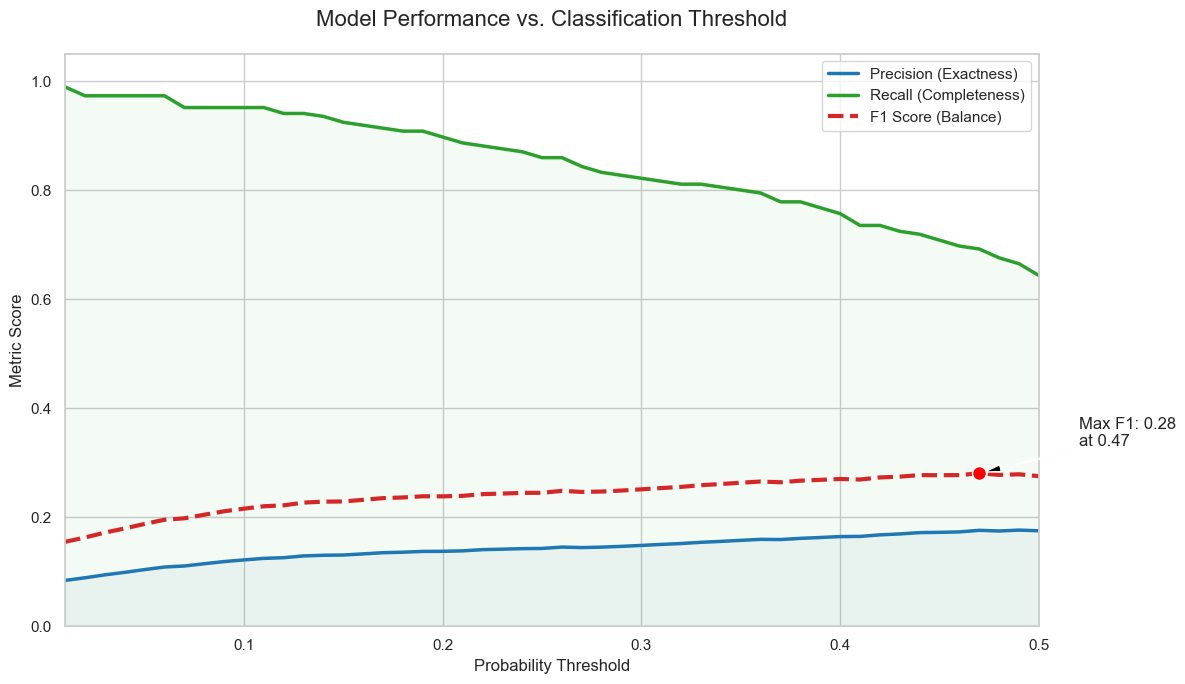

In [30]:
# Set a professional style
sns.set_theme(style="whitegrid")

# Identify the best F1 score for annotation
best_f1_row = tradeoff_df.loc[tradeoff_df['f1'].idxmax()]
max_f1_threshold = best_f1_row['threshold']
max_f1_score = best_f1_row['f1']

plt.figure(figsize=(12, 7))

# Plotting with improved styling and fills
plt.plot(tradeoff_df["threshold"], tradeoff_df["precision"], 
         label="Precision (Exactness)", color="#1f77b4", linewidth=2.5)
plt.fill_between(tradeoff_df["threshold"], tradeoff_df["precision"], alpha=0.05, color="#1f77b4")

plt.plot(tradeoff_df["threshold"], tradeoff_df["recall"], 
         label="Recall (Completeness)", color="#2ca02c", linewidth=2.5)
plt.fill_between(tradeoff_df["threshold"], tradeoff_df["recall"], alpha=0.05, color="#2ca02c")

plt.plot(tradeoff_df["threshold"], tradeoff_df["f1"], 
         label="F1 Score (Balance)", color="#d62728", linestyle="--", linewidth=3)

# Highlight the mathematical maximum F1
plt.scatter(max_f1_threshold, max_f1_score, color='red', s=100, zorder=5, edgecolor='white')
plt.annotate(f'Max F1: {max_f1_score:.2f}\nat {max_f1_threshold:.2f}',
             xy=(max_f1_threshold, max_f1_score),
             xytext=(max_f1_threshold + 0.05, max_f1_score + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))

# Final touches
plt.title("Model Performance vs. Classification Threshold", fontsize=16, pad=20)
plt.xlabel("Probability Threshold", fontsize=12)
plt.ylabel("Metric Score", fontsize=12)
plt.ylim(0, 1.05)
plt.xlim(tradeoff_df["threshold"].min(), tradeoff_df["threshold"].max())
plt.legend(frameon=True, facecolor='white', loc='upper right')

plt.tight_layout()
plt.show()

## 9. Metrics

In [ ]:
best_threshold = max_f1_threshold # 0.47
# for better recall use the following
# best_threshold = 0.05

# Predict probabilities
y_val_prob = model.predict_proba(X_val_final)[:, 1]

# Apply chosen threshold
y_val_pred = (y_val_prob >= best_threshold).astype(int)

# Metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, zero_division=0)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

print(f"Threshold      : {best_threshold}")
print(f"Accuracy       : {accuracy:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1 Score       : {f1:.4f}")

print("\nConfusion Matrix:")
print(cm)

# =========================================
# Threshold      : 0.05
# Accuracy       : 0.4945
# Precision      : 0.1038
# Recall         : 0.9730
# F1 Score       : 0.1876

# Confusion Matrix:
# [[1345 1554]
#  [   5  180]]
# =========================================
# Threshold      : 0.47000000000000003
# Accuracy       : 0.7870
# Precision      : 0.1758
# Recall         : 0.6919
# F1 Score       : 0.2804

# Confusion Matrix:
# [[2299  600]
#  [  57  128]]

Threshold      : 0.47000000000000003
Accuracy       : 0.7870
Precision      : 0.1758
Recall         : 0.6919
F1 Score       : 0.2804

Confusion Matrix:
[[2299  600]
 [  57  128]]


## 10. Save everything

In [32]:
# Define path to the models folder (one level up, then 'models')
models_path = os.path.join(current_dir, "..", "models")

# Save trained model and preprocessing assets
joblib.dump(model, os.path.join(models_path, "best_xgb_model.joblib"))
joblib.dump(encoder, os.path.join(models_path, "encoder.joblib"))
joblib.dump(scaler, os.path.join(models_path, "scaler.joblib"))
joblib.dump(feature_names, os.path.join(models_path, "feature_names.joblib"))
joblib.dump(X_val_final, os.path.join(models_path, "X_val.joblib"))
joblib.dump(y_val, os.path.join(models_path, "y_val.joblib"))

print("All artifacts saved.")

All artifacts saved.
